In [ ]:
#Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np
import tensorflow as tf 
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import keras.layers
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.layers import GaussianNoise
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
#Loading Image Data
with zipfile.ZipFile("Group_21_Assignment2.zip","r") as zip_ref:
    zip_ref.extractall()
zip_ref.close()

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

#**`Dataset`**

In [ ]:
#Train Data
train0 = np.array(load_images_from_folder("Group_21/train/0"))
train2 = np.array(load_images_from_folder("Group_21/train/2"))
train4 = np.array(load_images_from_folder("Group_21/train/4"))
train6 = np.array(load_images_from_folder("Group_21/train/6"))
train7 = np.array(load_images_from_folder("Group_21/train/7"))

train0 = train0.reshape((train0.shape[0],28*28))
train2 = train2.reshape((train2.shape[0],28*28))
train4 = train4.reshape((train4.shape[0],28*28))
train6 = train6.reshape((train6.shape[0],28*28))
train7 = train7.reshape((train7.shape[0],28*28))

x_train = np.concatenate([train0,train2,train4,train6,train7])
y_train = np.concatenate([0+np.zeros(len(train0)),2+np.zeros(len(train2)),4+np.zeros(len(train4)),
                          6+np.zeros(len(train6)),7+np.zeros(len(train7))])

#Validation Data
val0 = np.array(load_images_from_folder("Group_21/val/0"))
val2 = np.array(load_images_from_folder("Group_21/val/2"))
val4 = np.array(load_images_from_folder("Group_21/val/4"))
val6 = np.array(load_images_from_folder("Group_21/val/6"))
val7 = np.array(load_images_from_folder("Group_21/val/7"))

val0 = val0.reshape((val0.shape[0],28*28))
val2 = val2.reshape((val2.shape[0],28*28))
val4 = val4.reshape((val4.shape[0],28*28))
val6 = val6.reshape((val6.shape[0],28*28))
val7 = val7.reshape((val7.shape[0],28*28))

x_val = np.concatenate([val0,val2,val4,val6,val7])
y_val = np.concatenate([0+np.zeros(len(val0)),2+np.zeros(len(val2)),4+np.zeros(len(val4)),
                          6+np.zeros(len(val6)),7+np.zeros(len(val7))])

#Test Data
test0 = np.array(load_images_from_folder("Group_21/test/0"))
test2 = np.array(load_images_from_folder("Group_21/test/2"))
test4 = np.array(load_images_from_folder("Group_21/test/4"))
test6 = np.array(load_images_from_folder("Group_21/test/6"))
test7 = np.array(load_images_from_folder("Group_21/test/7"))

test0 = test0.reshape((test0.shape[0],28*28))
test2 = test2.reshape((test2.shape[0],28*28))
test4 = test4.reshape((test4.shape[0],28*28))
test6 = test6.reshape((test6.shape[0],28*28))
test7 = test7.reshape((test7.shape[0],28*28))

x_test = np.concatenate([test0,test2,test4,test6,test7])
y_test = np.concatenate([0+np.zeros(len(test0)),2+np.zeros(len(test2)),4+np.zeros(len(test4)),
                          6+np.zeros(len(test6)),7+np.zeros(len(test7))])

del train0,train2,train4,train6,train7
del val0,val2,val4,val6,val7
del test0,test2,test4,test6,test7

#Normalizing Input
x_train,x_val,x_test = x_train/255,x_val/255,x_test/255

#**`FCNN with 3 Hidden Layers`**

In [ ]:
#Converting one hot encoded test label to label
def ohetolabel(array): 
  output = list()
  for i in range(len(array)):
    output.append(np.argmax(array[i]))
  return np.array(output)

In [ ]:
#Plot cf matrix
def cf_matrix_plot(cf_matrix,title):
  #group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(5,5)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title(title);
  ax.set_xlabel('\nPredicted Image Class')
  ax.set_ylabel('Actual Image Class');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['0','2','4','6','7'])
  ax.yaxis.set_ticklabels(['0','2','4','6','7'])

In [ ]:
# Neural network
def clf_1_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,C,optimizer,batch_size,error_th,p,epochs=1e3):
  model = Sequential()
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid'))
  model.add(Dense(C, activation='softmax'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=p)
  if optimizer not in ["SGD","RMSProp","Adam"]:
    opt = "SGD"
  else:
    opt = optimizer

  #One Hot Encoding
  ohe = OneHotEncoder()
  y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
  y_val = ohe.fit_transform(y_val.reshape(-1,1)).toarray()
  y_test = ohe.fit_transform(y_test.reshape(-1,1)).toarray()

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train, y_train,validation_data = (x_val,y_val) ,epochs=int(epochs), batch_size=batch_size,callbacks=[es])

  y_train_pred = model.predict(x_train)
  y_val_pred   = model.predict(x_val)
  y_test_pred  = model.predict(x_test)

  y_train_pred = ohetolabel(y_train_pred)
  y_val_pred   = ohetolabel(y_val_pred)
  y_test_pred  = ohetolabel(y_test_pred)
  
  y_train = ohetolabel(y_train)
  y_val   = ohetolabel(y_val)
  y_test  = ohetolabel(y_test)
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],marker='.')
  plt.plot(history.history['val_accuracy'],marker='.')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Accuracy =\t",history.history['accuracy'][-1])
  print("Validation Accuracy =\t",history.history['val_accuracy'][-1])

    
  #Generate the confusion matrix
  plt.figure(figsize=(12.5,4))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,3,1)
  cf_matrix = confusion_matrix(y_train, y_train_pred)
  cf_matrix_plot(cf_matrix,"Training Data")
  
  plt.subplot(1,3,2)
  cf_matrix = confusion_matrix(y_val, y_val_pred)
  cf_matrix_plot(cf_matrix,"Validation Data")

  plt.subplot(1,3,3)
  cf_matrix = confusion_matrix(y_test, y_test_pred)
  cf_matrix_plot(cf_matrix,"Test Data")  
  plt.tight_layout()
  plt.show()

  print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
  print("Accuracy:",end=" ")
  print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
  print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
  print(np.around(accuracy_score(y_test , y_test_pred),4))

  print("Precision:",end="")
  print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

  print("Recall:",end="   ")
  print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

  print("F1-Score:",end=" ")
  print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))


In [ ]:
# Neural network
def clf_2_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,C,optimizer,batch_size,error_th,p,epochs=1e3):
  model = Sequential()
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid'))
  model.add(Dense(node2, activation="sigmoid"))
  model.add(Dense(C, activation='softmax'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=p)
  if optimizer not in ["SGD","RMSProp","Adam"]:
    opt = "SGD"
  else:
    opt = optimizer

  #One Hot Encoding
  ohe = OneHotEncoder()
  y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
  y_val = ohe.fit_transform(y_val.reshape(-1,1)).toarray()
  y_test = ohe.fit_transform(y_test.reshape(-1,1)).toarray()

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train, y_train,validation_data = (x_val,y_val) ,epochs=int(epochs), batch_size=batch_size,callbacks=[es])

  y_train_pred = model.predict(x_train)
  y_val_pred   = model.predict(x_val)
  y_test_pred  = model.predict(x_test)

  y_train_pred = ohetolabel(y_train_pred)
  y_val_pred   = ohetolabel(y_val_pred)
  y_test_pred  = ohetolabel(y_test_pred)
  
  y_train = ohetolabel(y_train)
  y_val   = ohetolabel(y_val)
  y_test  = ohetolabel(y_test)
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],marker='.')
  plt.plot(history.history['val_accuracy'],marker='.')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Accuracy =\t",history.history['accuracy'][-1])
  print("Validation Accuracy =\t",history.history['val_accuracy'][-1])

    
  #Generate the confusion matrix
  plt.figure(figsize=(12.5,4))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,3,1)
  cf_matrix = confusion_matrix(y_train, y_train_pred)
  cf_matrix_plot(cf_matrix,"Training Data")
  
  plt.subplot(1,3,2)
  cf_matrix = confusion_matrix(y_val, y_val_pred)
  cf_matrix_plot(cf_matrix,"Validation Data")

  plt.subplot(1,3,3)
  cf_matrix = confusion_matrix(y_test, y_test_pred)
  cf_matrix_plot(cf_matrix,"Test Data")  
  plt.tight_layout()
  plt.show()

  print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
  print("Accuracy:",end=" ")
  print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
  print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
  print(np.around(accuracy_score(y_test , y_test_pred),4))

  print("Precision:",end="")
  print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

  print("Recall:",end="   ")
  print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

  print("F1-Score:",end=" ")
  print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))

In [ ]:
# Neural network
def clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e3):
  
  tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=42)
  model = Sequential()
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid',
                  kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(Dense(node2, activation="sigmoid",
                  kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(Dense(node3, activation='sigmoid',
                  kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(Dense(C, activation='softmax',
                  kernel_initializer='random_normal',bias_initializer='zeros'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=p)
  if optimizer not in ["SGD","RMSProp","Adam"]:
    opt = "SGD"
  else:
    opt = optimizer

  #One Hot Encoding
  ohe = OneHotEncoder()
  y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
  y_val = ohe.fit_transform(y_val.reshape(-1,1)).toarray()
  y_test = ohe.fit_transform(y_test.reshape(-1,1)).toarray()

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train, y_train,validation_data = (x_val,y_val) ,epochs=int(epochs), batch_size=batch_size,callbacks=[es])

  y_train_pred = model.predict(x_train)
  y_val_pred   = model.predict(x_val)
  y_test_pred  = model.predict(x_test)

  y_train_pred = ohetolabel(y_train_pred)
  y_val_pred   = ohetolabel(y_val_pred)
  y_test_pred  = ohetolabel(y_test_pred)
  
  y_train = ohetolabel(y_train)
  y_val   = ohetolabel(y_val)
  y_test  = ohetolabel(y_test)
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],marker='.')
  plt.plot(history.history['val_accuracy'],marker='.')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Accuracy =\t",history.history['accuracy'][-1])
  print("Validation Accuracy =\t",history.history['val_accuracy'][-1])

    
  #Generate the confusion matrix
  plt.figure(figsize=(12.5,4))
  plt.suptitle(optimizer,fontweight="bold",y=1+1e-2)
  plt.subplot(1,3,1)
  cf_matrix = confusion_matrix(y_train, y_train_pred)
  cf_matrix_plot(cf_matrix,"Training Data")
  
  plt.subplot(1,3,2)
  cf_matrix = confusion_matrix(y_val, y_val_pred)
  cf_matrix_plot(cf_matrix,"Validation Data")

  plt.subplot(1,3,3)
  cf_matrix = confusion_matrix(y_test, y_test_pred)
  cf_matrix_plot(cf_matrix,"Test Data")  
  plt.tight_layout()
  plt.show()

  print("\tTraining Data\t\t\t\tValidation Data\t\t\t\tTest Data")
  print("Accuracy:",end=" ")
  print(np.around(accuracy_score(y_train , y_train_pred),4),end="\t"*4)
  print(np.around(accuracy_score(y_val , y_val_pred),4),end="\t"*5)
  print(np.around(accuracy_score(y_test , y_test_pred),4))

  print("Precision:",end="")
  print(np.around(precision_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(precision_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(precision_score(y_test , y_test_pred,average="macro"),4))

  print("Recall:",end="   ")
  print(np.around(recall_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(recall_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(recall_score(y_test , y_test_pred,average="macro"),4))

  print("F1-Score:",end=" ")
  print(np.around(f1_score(y_train , y_train_pred,average="macro"),4),end="\t"*4)
  print(np.around(f1_score(y_val , y_val_pred,average="macro"),4),end="\t"*5)
  print(np.around(f1_score(y_test , y_test_pred,average="macro"),4))

In [ ]:
node1 = 30
node2 = 20
node3 = 10
C = 5
error_th = 1e-4
p = 1

Epoch 1/100000
11385/11385 [==============================] - 21s 2ms/step - loss: 1.6168 - accuracy: 0.1924 - val_loss: 1.6168 - val_accuracy: 0.2000
Epoch 2/100000
11385/11385 [==============================] - 22s 2ms/step - loss: 1.6153 - accuracy: 0.1963 - val_loss: 1.6119 - val_accuracy: 0.2000
Epoch 3/100000
11385/11385 [==============================] - 20s 2ms/step - loss: 1.6133 - accuracy: 0.2040 - val_loss: 1.6158 - val_accuracy: 0.2000
Epoch 4/100000
11385/11385 [==============================] - 21s 2ms/step - loss: 1.6133 - accuracy: 0.1984 - val_loss: 1.6227 - val_accuracy: 0.2000
Epoch 4: early stopping
No of Epochs = 4


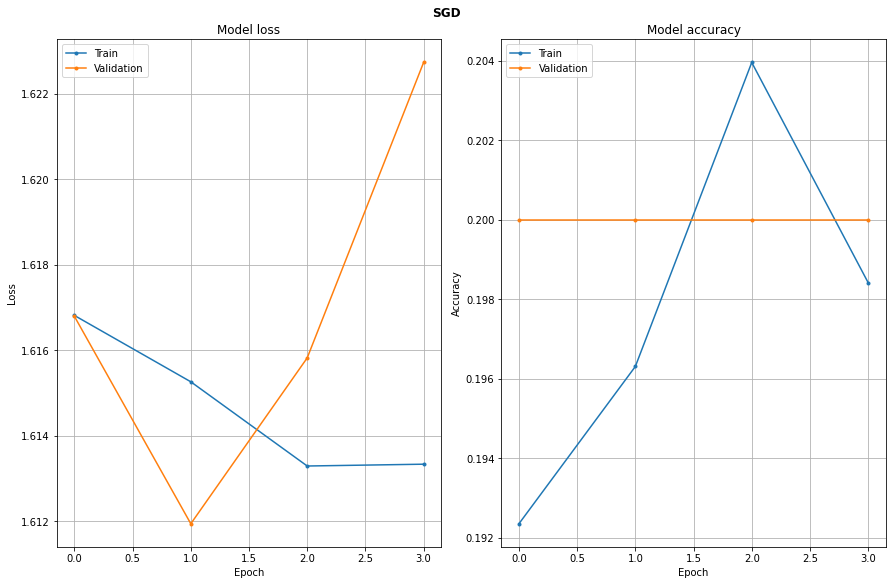

Training Accuracy =	 0.1984189748764038
Validation Accuracy =	 0.20000000298023224


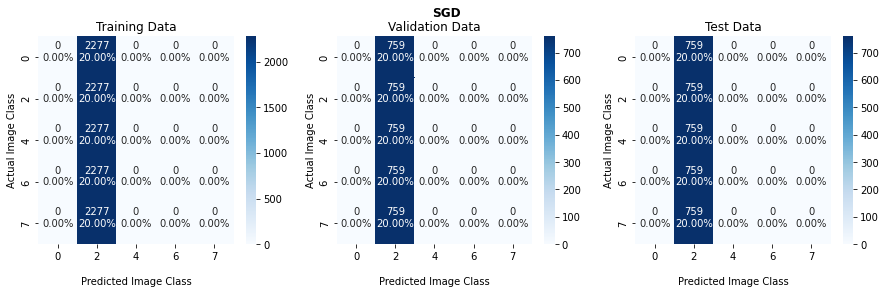

	Training Data				Validation Data				Test Data
Accuracy: 0.2				0.2					0.2
Precision:0.04				0.04					0.04
Recall:   0.2				0.2					0.2
F1-Score: 0.0667				0.0667					0.0667


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
optimizer ='SGD'
batch_size = 1
tensorflow.keras.optimizers.SGD(learning_rate=0.001)
clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

Epoch 1/100000
356/356 [==============================] - 1s 3ms/step - loss: 1.6190 - accuracy: 0.2126 - val_loss: 1.6070 - val_accuracy: 0.2335
Epoch 2/100000
356/356 [==============================] - 1s 2ms/step - loss: 1.6062 - accuracy: 0.2459 - val_loss: 1.6044 - val_accuracy: 0.2480
Epoch 2: early stopping
No of Epochs = 2


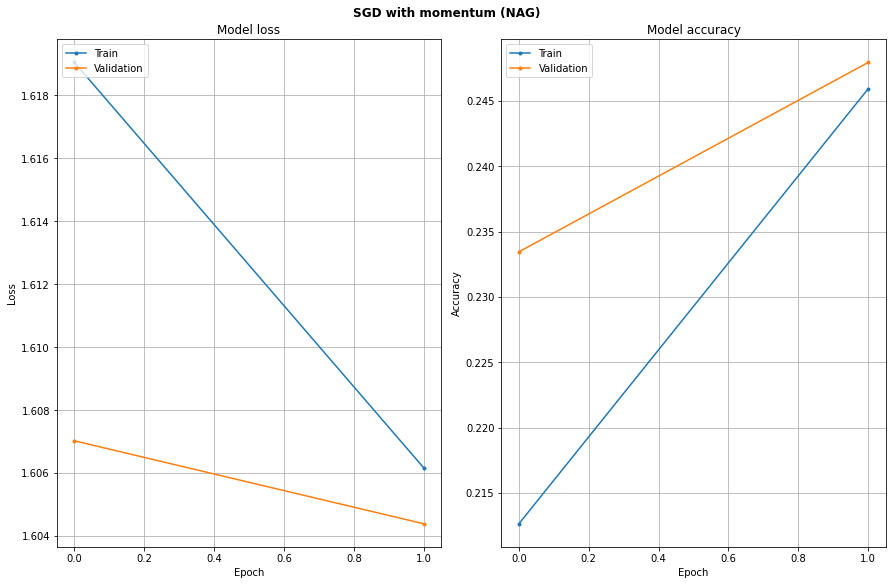

Training Accuracy =	 0.24593763053417206
Validation Accuracy =	 0.24795784056186676


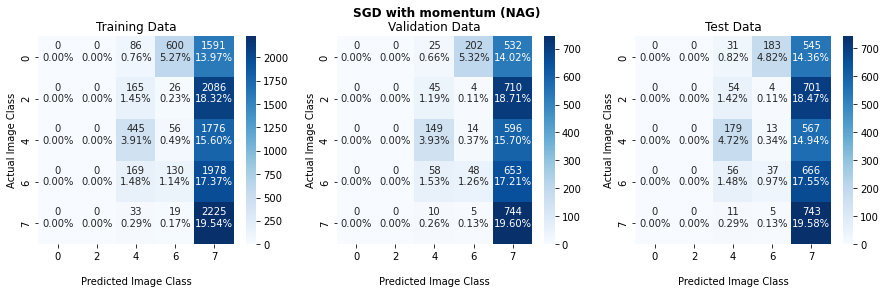

	Training Data				Validation Data				Test Data
Accuracy: 0.2459				0.248					0.2527
Precision:0.1765				0.185					0.1849
Recall:   0.2459				0.248					0.2527
F1-Score: 0.1474				0.1501					0.1551


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
optimizer  ='SGD with momentum (NAG)'
batch_size = 32
tensorflow.keras.optimizers.SGD(learning_rate=0.001,momentum = 0.9,nesterov=True)
clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 54ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97502/100000
1/1 [==============================] - 0s 55ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97503/100000
1/1 [==============================] - 0s 62ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97504/100000
1/1 [==============================] - 0s 58ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97505/100000
1/1 [==============================] - 0s 57ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97506/100000
1/1 [==============================] - 0s 56ms/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 97507/100000
1/1 [==============================] - 0s 55ms/step - loss: 0.0323 

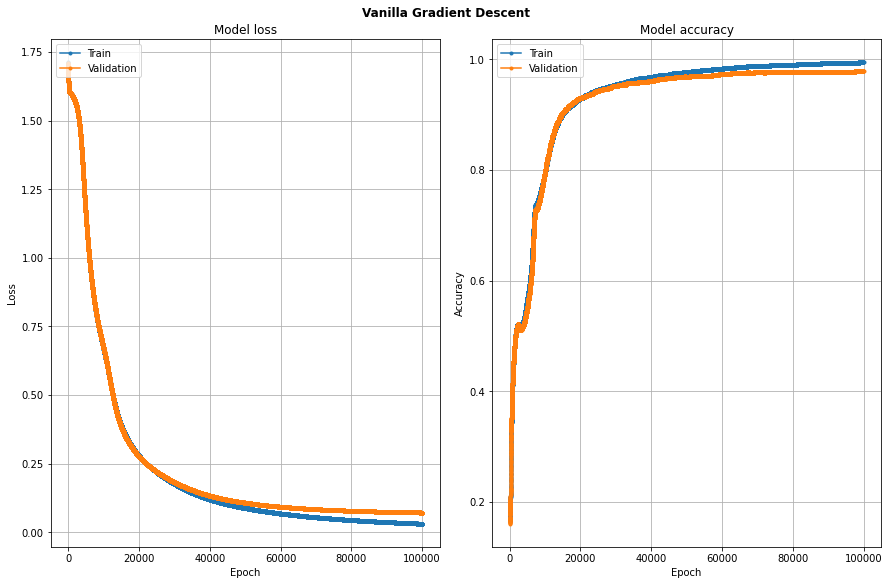

Training Accuracy =	 0.9943785667419434
Validation Accuracy =	 0.9783926010131836


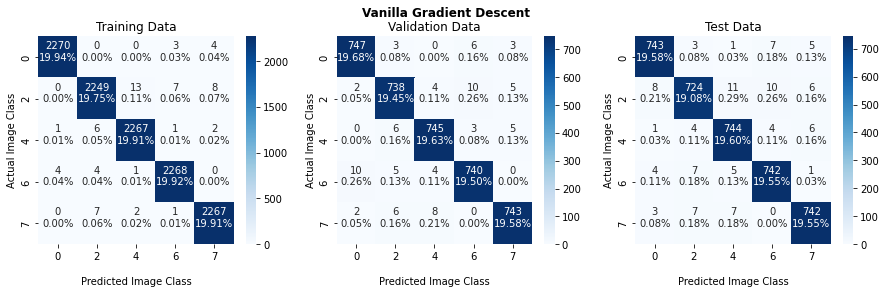

	Training Data				Validation Data				Test Data
Accuracy: 0.9944				0.9784					0.9736
Precision:0.9944				0.9784					0.9737
Recall:   0.9944				0.9784					0.9736
F1-Score: 0.9944				0.9784					0.9736


In [ ]:
optimizer  ='Vanilla Gradient Descent'
batch_size = len(x_train)
tensorflow.keras.optimizers.SGD(learning_rate=0.001)
clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p=1000,epochs=1e5)

Epoch 1/100000
356/356 [==============================] - 3s 7ms/step - loss: 1.6277 - accuracy: 0.2050 - val_loss: 1.6065 - val_accuracy: 0.2040
Epoch 2/100000
356/356 [==============================] - 2s 5ms/step - loss: 1.6048 - accuracy: 0.2836 - val_loss: 1.6023 - val_accuracy: 0.2161
Epoch 3/100000
356/356 [==============================] - 2s 4ms/step - loss: 1.6005 - accuracy: 0.3540 - val_loss: 1.5978 - val_accuracy: 0.3486
Epoch 4/100000
356/356 [==============================] - 2s 4ms/step - loss: 1.5957 - accuracy: 0.3927 - val_loss: 1.5925 - val_accuracy: 0.3921
Epoch 5/100000
356/356 [==============================] - 1s 4ms/step - loss: 1.5897 - accuracy: 0.4212 - val_loss: 1.5860 - val_accuracy: 0.5618
Epoch 6/100000
356/356 [==============================] - 1s 4ms/step - loss: 1.5826 - accuracy: 0.5517 - val_loss: 1.5776 - val_accuracy: 0.5404
Epoch 7/100000
356/356 [==============================] - 2s 5ms/step - loss: 1.5729 - accuracy: 0.5698 - val_loss: 1.5661 -

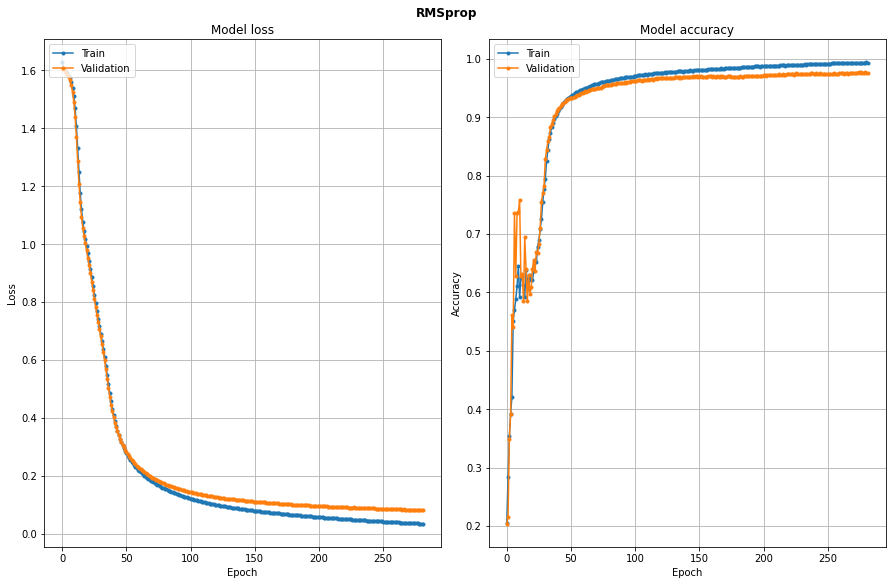

Training Accuracy =	 0.9936758875846863
Validation Accuracy =	 0.9762845635414124


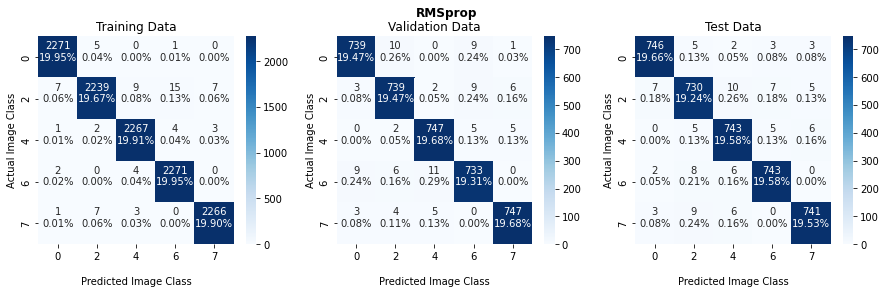

	Training Data				Validation Data				Test Data
Accuracy: 0.9938				0.9763					0.9758
Precision:0.9938				0.9763					0.9758
Recall:   0.9938				0.9763					0.9758
F1-Score: 0.9938				0.9763					0.9758


In [ ]:
optimizer  ='RMSprop'
batch_size = 32
tensorflow.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9, rho = 0.99)
clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

Epoch 1/100000
356/356 [==============================] - 2s 3ms/step - loss: 1.5091 - accuracy: 0.3277 - val_loss: 1.2409 - val_accuracy: 0.4406
Epoch 2/100000
356/356 [==============================] - 1s 3ms/step - loss: 1.0389 - accuracy: 0.6523 - val_loss: 0.8403 - val_accuracy: 0.7586
Epoch 3/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.7024 - accuracy: 0.7638 - val_loss: 0.5906 - val_accuracy: 0.7734
Epoch 4/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.5367 - accuracy: 0.7766 - val_loss: 0.4867 - val_accuracy: 0.7808
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.4604 - accuracy: 0.7954 - val_loss: 0.4388 - val_accuracy: 0.8535
Epoch 6/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.4118 - accuracy: 0.8582 - val_loss: 0.3976 - val_accuracy: 0.9154
Epoch 7/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.3148 - accuracy: 0.9547 - val_loss: 0.2601 -

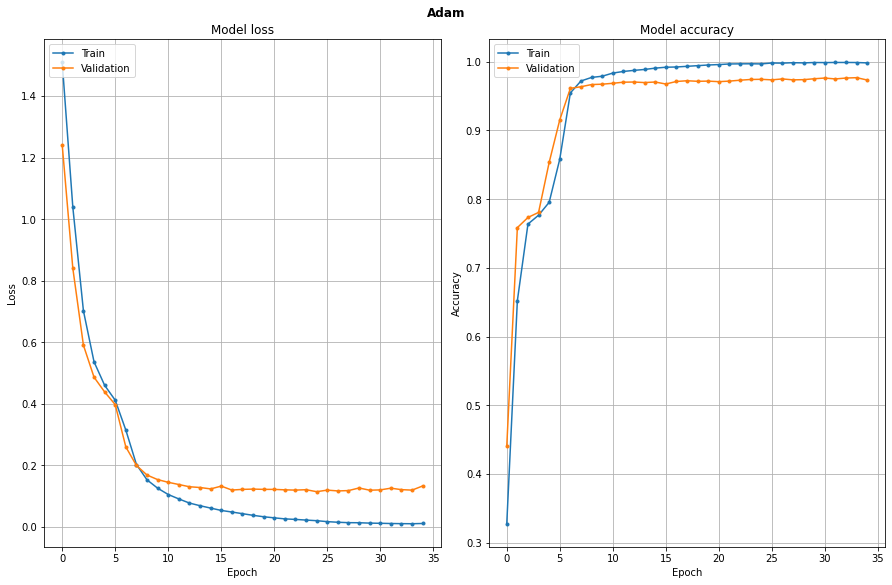

Training Accuracy =	 0.9983311295509338
Validation Accuracy =	 0.9733860492706299


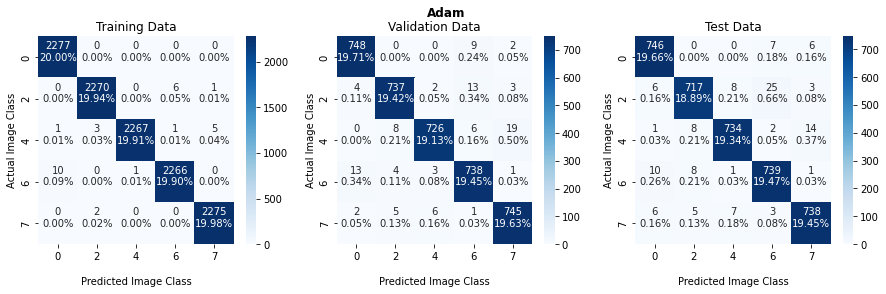

	Training Data				Validation Data				Test Data
Accuracy: 0.9974				0.9734					0.9681
Precision:0.9974				0.9735					0.9682
Recall:   0.9974				0.9734					0.9681
F1-Score: 0.9974				0.9734					0.9681


In [ ]:
optimizer  ='Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_3_layer(x_train,y_train,x_val,y_val,x_test,y_test,node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

#**`AutoEncoder`**

##**`AutoEncoder with 1 Hidden Layers`**

In [ ]:
# Auto Encoder
def autoencoder_1_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,optimizer,batch_size,error_th,epochs=1e3):
  model = Sequential()
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid'))
  model.add(Dense(x_train.shape[1], activation='linear'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=1)

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
  history = model.fit(x_train, x_train,validation_data = (x_val,x_val) ,epochs=int(epochs), batch_size=batch_size,callbacks=[es])
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle("1 Hidden Layer",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Loss\t=",history.history['loss'][-1])
  print("Validation Loss\t=",history.history['val_loss'][-1])
  
  x_train_pred = model.predict(x_train)
  x_val_pred   = model.predict(x_val)
  x_test_pred  = model.predict(x_test)
  test_loss = ((x_test-x_test_pred)**2).mean()
  print("Test Loss\t=",test_loss)
  
  plt.figure(figsize=(12.5,4))
  plt.suptitle("Average Reconstruction Error vs Data",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.bar(height = [history.history['loss'][-1],history.history['val_loss'][-1],test_loss],x = ['Training Data','Validation Data','Test Data'])
  plt.ylabel('Average Reconstruction Error') 
  plt.xlabel('Data') 
  plt.grid()
  plt.tight_layout();plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  C = set(y_train)
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train_pred[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:  
    plt.subplot(1,5,index)
    plt.imshow(x_val[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_val_pred[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Weight Visualization
  plt.figure(figsize=(12.5,node1))
  plt.suptitle("Weight Vizualization",fontweight="bold",y=1+1e-2)  
  weights = model.layers[0].get_weights()
  index = 1
  for i in range(node1):
    plt.subplot(node1//4,4,index) 
    img = weights[0].T[i]
    img /= np.sqrt(sum(img**2))
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.title("Hidden Node "+str(int(i+1)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Encoder
  model2 = Sequential()
  model2.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid', weights=model.layers[0].get_weights()))

  x_train_compress = model2.predict(x_train)
  x_val_compress = model2.predict(x_val)
  x_test_compress = model2.predict(x_test)
  return x_train_compress,x_val_compress,x_test_compress

Epoch 1/100000
356/356 [==============================] - 3s 7ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 2/100000
356/356 [==============================] - 2s 5ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 3/100000
356/356 [==============================] - 2s 5ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 4/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 6/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoc

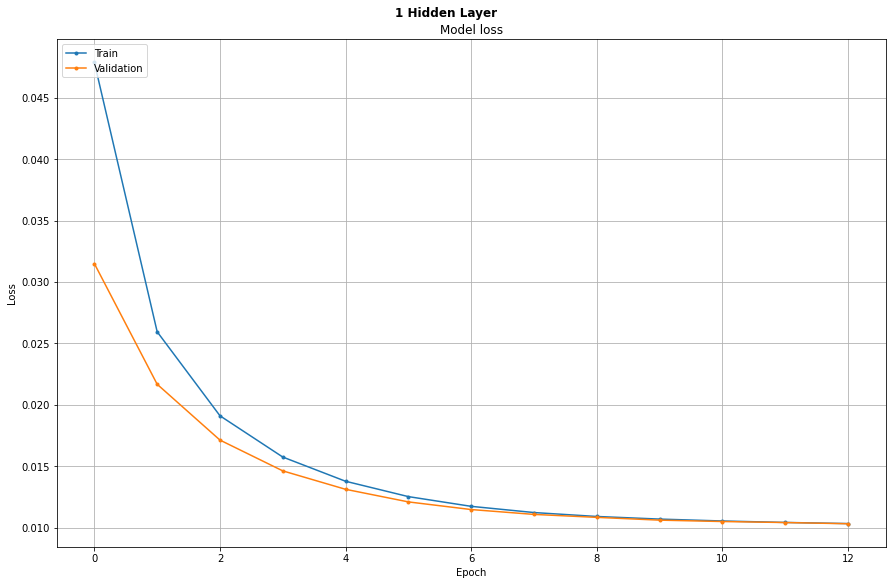

Training Loss	= 0.010343990288674831
Validation Loss	= 0.010330144315958023
Test Loss	= 0.010465277417817383


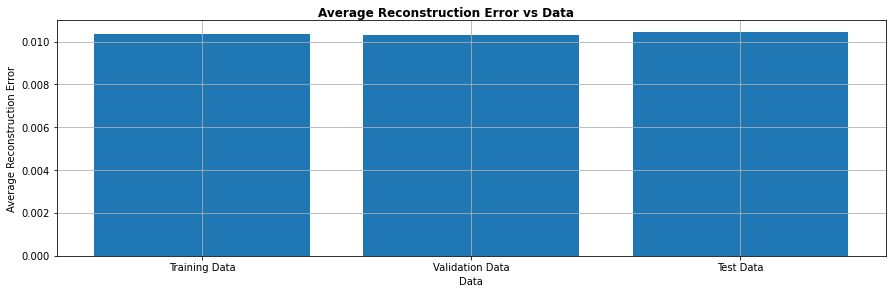

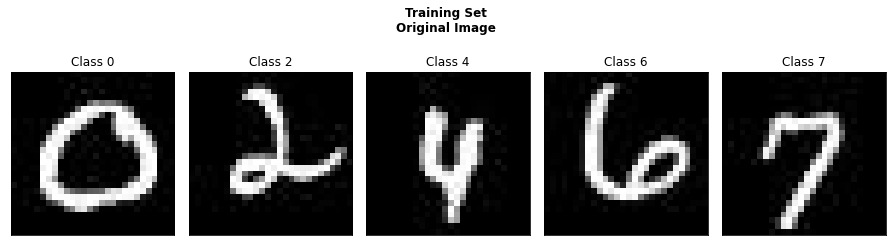

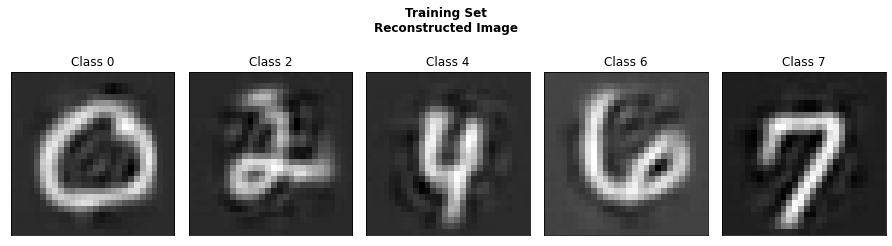

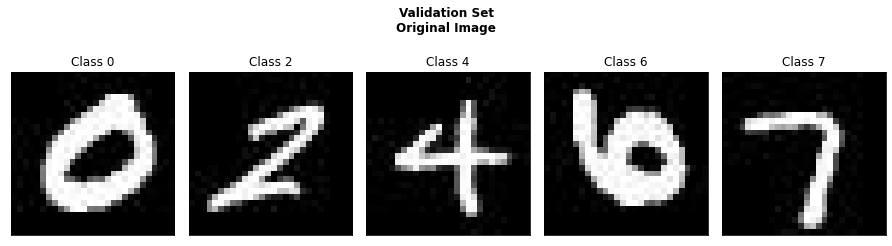

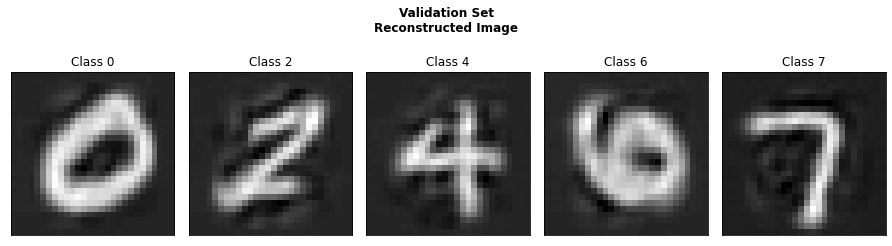

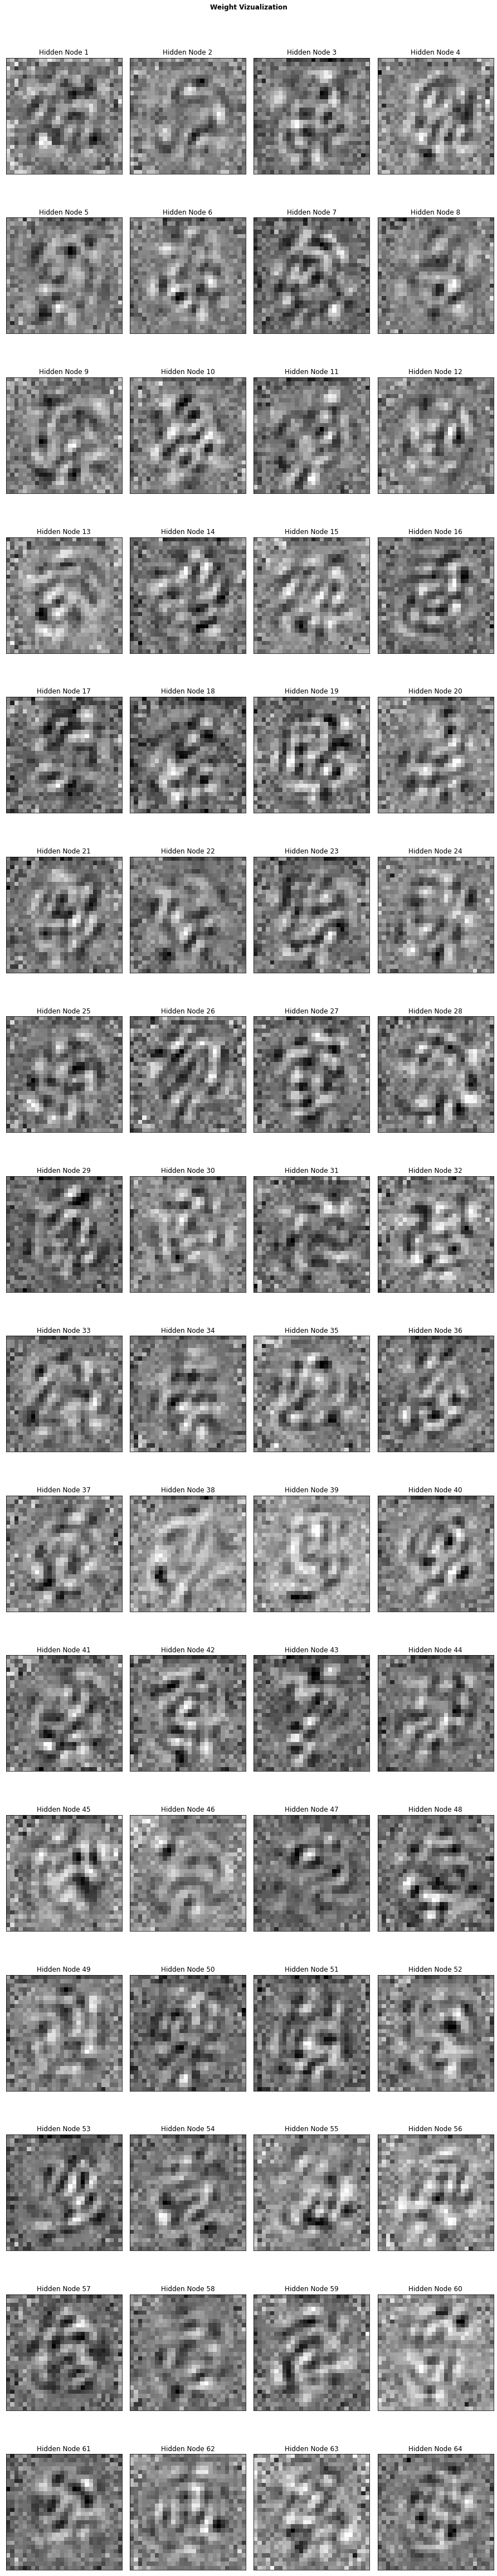

In [ ]:
node1 = 64
epochs = 1e5
error_th = 1e-4
optimizer = 'Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
x_train_compress,x_val_compress,x_test_compress = autoencoder_1_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,optimizer,batch_size,error_th,epochs)

Epoch 1/100000
356/356 [==============================] - 2s 4ms/step - loss: 1.6329 - accuracy: 0.2278 - val_loss: 1.5969 - val_accuracy: 0.2074
Epoch 2/100000
356/356 [==============================] - 1s 3ms/step - loss: 1.5472 - accuracy: 0.4325 - val_loss: 1.4107 - val_accuracy: 0.6408
Epoch 3/100000
356/356 [==============================] - 1s 3ms/step - loss: 1.0987 - accuracy: 0.7301 - val_loss: 0.8465 - val_accuracy: 0.7792
Epoch 4/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.7106 - accuracy: 0.8134 - val_loss: 0.6117 - val_accuracy: 0.8216
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.5527 - accuracy: 0.8344 - val_loss: 0.5096 - val_accuracy: 0.8527
Epoch 6/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.4731 - accuracy: 0.8580 - val_loss: 0.4429 - val_accuracy: 0.8646
Epoch 7/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.4174 - accuracy: 0.8736 - val_loss: 0.3920 -

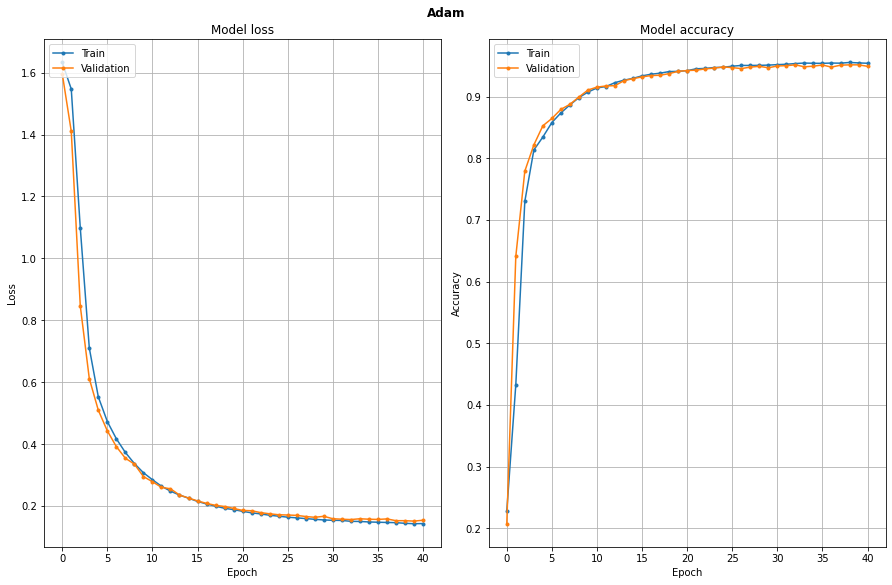

Training Accuracy =	 0.9540623426437378
Validation Accuracy =	 0.9491435885429382


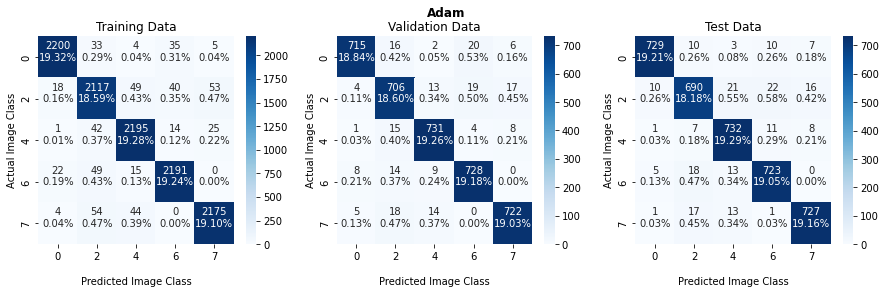

	Training Data				Validation Data				Test Data
Accuracy: 0.9555				0.9491					0.9489
Precision:0.9556				0.9494					0.949
Recall:   0.9555				0.9491					0.9489
F1-Score: 0.9555				0.9492					0.9488


In [ ]:
#FCNN using Adam optimizer for classification.
node1 = 30
node2 = 20
node3 = 10
C = 5
error_th = 1e-4
p = 1

optimizer  ='Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_3_layer(x_train_compress,y_train,x_val_compress,y_val,x_test_compress,y_test,
            node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

##**`AutoEncoder with 3 Hidden Layers`**

In [ ]:
# Auto Encoder
def autoencoder_3_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,node2,optimizer,batch_size,error_th,epochs=1e3):
  model = Sequential()
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid'))
  model.add(Dense(node2, activation='sigmoid'))
  model.add(Dense(node1, activation='sigmoid'))
  model.add(Dense(x_train.shape[1], activation='linear'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=1)

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
  history = model.fit(x_train, x_train,validation_data = (x_val,x_val) ,epochs=int(epochs), batch_size=batch_size,callbacks=[es])
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle("3 Hidden Layer",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Loss\t=",history.history['loss'][-1])
  print("Validation Loss\t=",history.history['val_loss'][-1])
  
  x_train_pred = model.predict(x_train)
  x_val_pred   = model.predict(x_val)
  x_test_pred  = model.predict(x_test)
  test_loss = ((x_test-x_test_pred)**2).mean()
  print("Test Loss\t=",test_loss)
  
  plt.figure(figsize=(12.5,4))
  plt.suptitle("Average Reconstruction Error vs Data",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.bar(height = [history.history['loss'][-1],history.history['val_loss'][-1],test_loss],x = ['Training Data','Validation Data','Test Data'])
  plt.ylabel('Average Reconstruction Error') 
  plt.xlabel('Data') 
  plt.grid()
  plt.tight_layout();plt.show()
  
  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  C = set(y_train)
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train_pred[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:  
    plt.subplot(1,5,index)
    plt.imshow(x_val[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_val_pred[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Weight Visualization
  plt.figure(figsize=(12.5,node2))
  plt.suptitle("Weight Vizualization",fontweight="bold",y=1+1e-2)  
  weights = model.layers[1].get_weights()
  index = 1
  for i in range(node2):
    plt.subplot(node2//4,4,index) 
    img = weights[0].T[i]
    img /= np.sqrt(sum(img**2))
    plt.imshow(img.reshape(16,16),cmap='gray')
    plt.title("Hidden Node "+str(int(i+1)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Encoder
  model2 = Sequential()
  model2.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid', weights=model.layers[0].get_weights()))
  model2.add(Dense(node2, activation='sigmoid',weights=model.layers[1].get_weights()))
  
  x_train_compress = model2.predict(x_train)
  x_val_compress = model2.predict(x_val)
  x_test_compress = model2.predict(x_test)
  return x_train_compress,x_val_compress,x_test_compress

Epoch 1/100000
356/356 [==============================] - 3s 7ms/step - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 2/100000
356/356 [==============================] - 2s 7ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 3/100000
356/356 [==============================] - 2s 7ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 4/100000
356/356 [==============================] - 2s 7ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 5/100000
356/356 [==============================] - 2s 6ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 6/100000
356/356 [==============================] - 2s 7ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoc

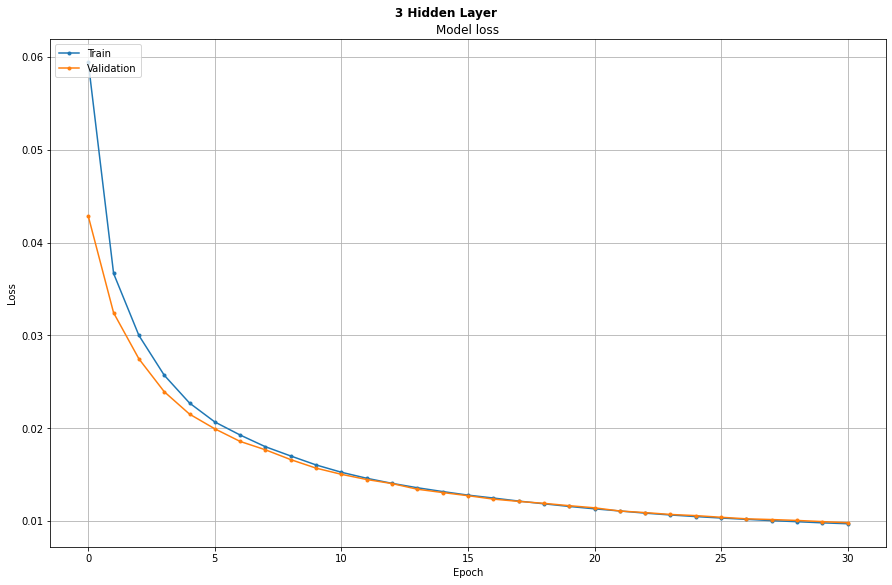

Training Loss	= 0.009714833460748196
Validation Loss	= 0.009817659854888916
Test Loss	= 0.009917869109591809


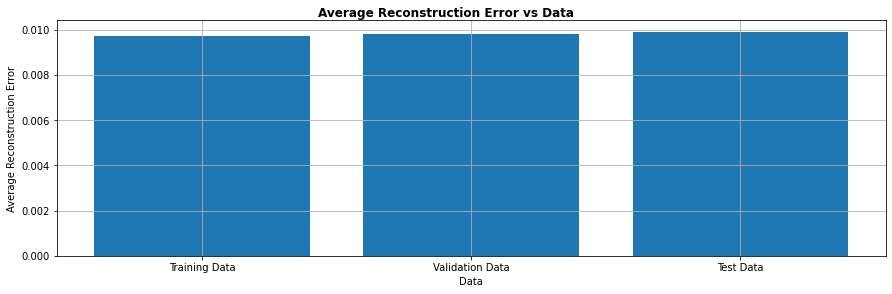

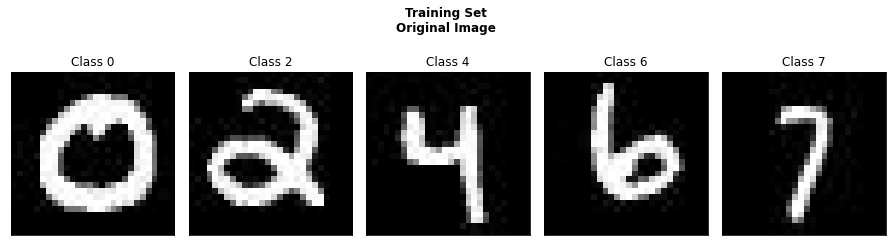

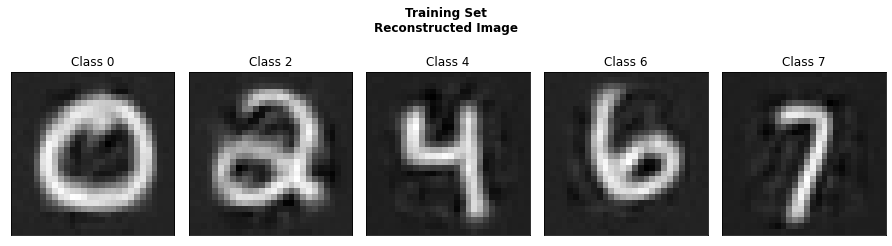

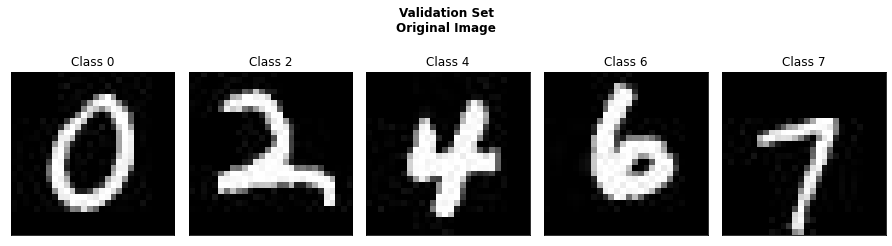

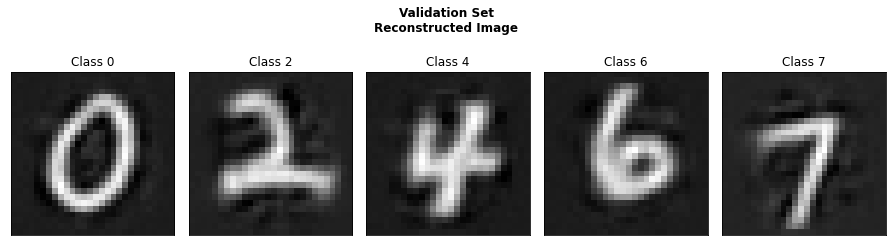

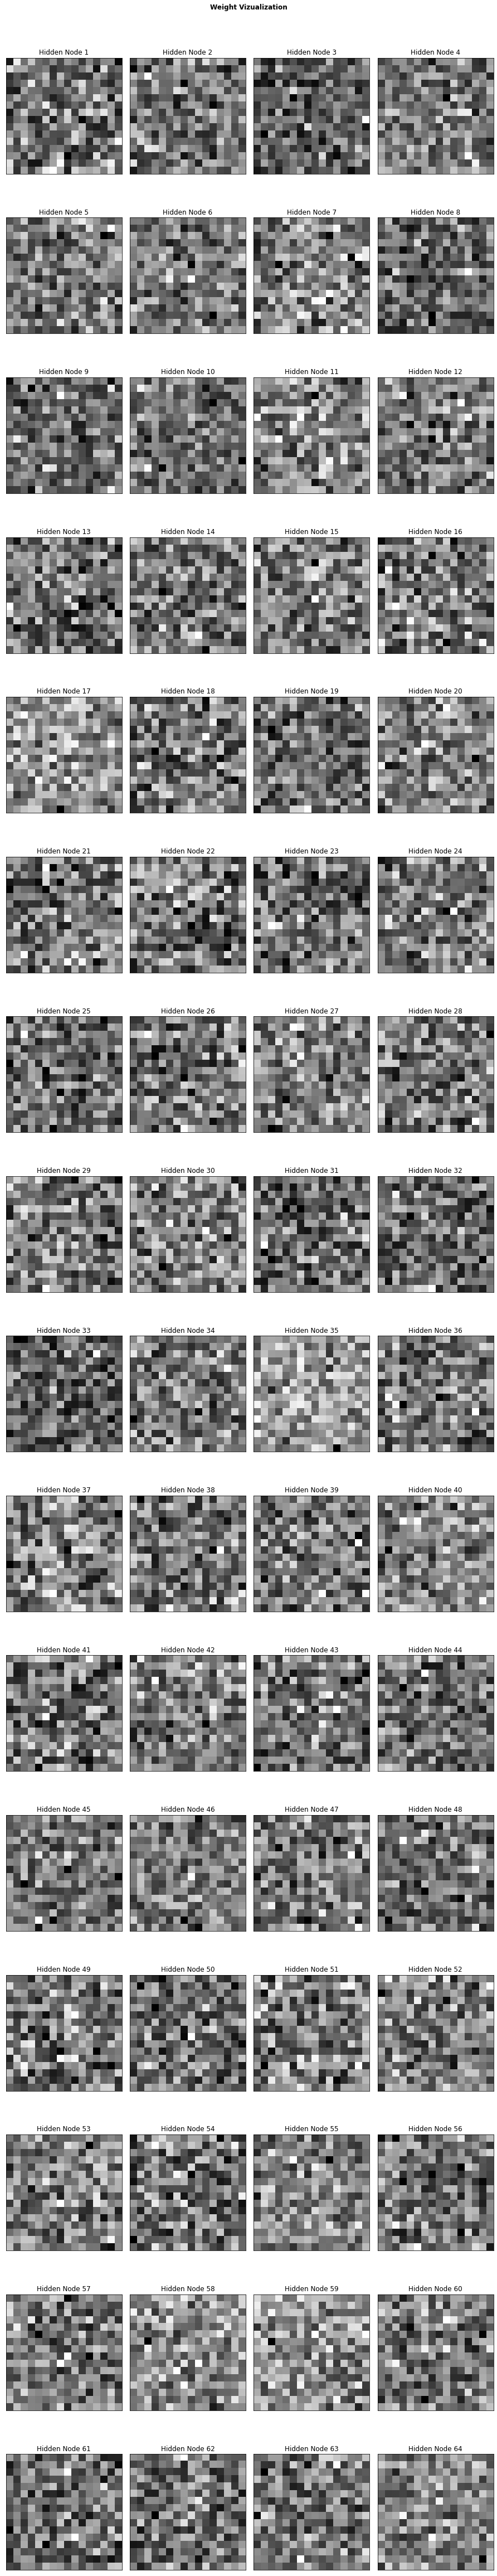

In [ ]:
node1 = 256
node2 = 64
epochs = 1e5
error_th = 1e-4
optimizer = 'Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
x_train_compress,x_val_compress,x_test_compress = autoencoder_3_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,node2,optimizer,batch_size,error_th,epochs)

Epoch 1/100000
356/356 [==============================] - 2s 5ms/step - loss: 1.6267 - accuracy: 0.2326 - val_loss: 1.5854 - val_accuracy: 0.3736
Epoch 2/100000
356/356 [==============================] - 2s 4ms/step - loss: 1.3914 - accuracy: 0.5931 - val_loss: 1.0576 - val_accuracy: 0.7165
Epoch 3/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.8324 - accuracy: 0.7505 - val_loss: 0.6826 - val_accuracy: 0.8192
Epoch 4/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.6053 - accuracy: 0.8338 - val_loss: 0.5344 - val_accuracy: 0.8596
Epoch 5/100000
356/356 [==============================] - 2s 5ms/step - loss: 0.4781 - accuracy: 0.8848 - val_loss: 0.4155 - val_accuracy: 0.9067
Epoch 6/100000
356/356 [==============================] - 2s 5ms/step - loss: 0.3801 - accuracy: 0.9146 - val_loss: 0.3416 - val_accuracy: 0.9181
Epoch 7/100000
356/356 [==============================] - 2s 5ms/step - loss: 0.3203 - accuracy: 0.9244 - val_loss: 0.2991 -

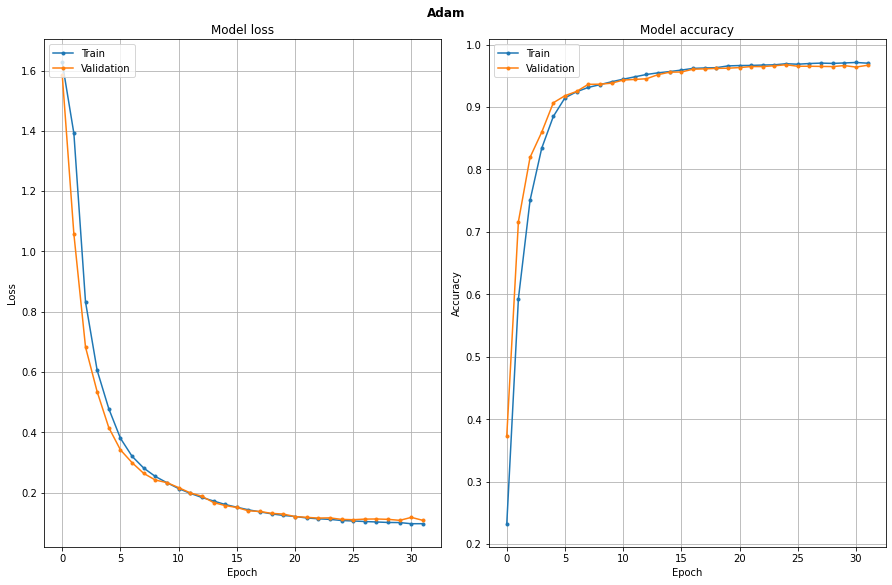

Training Accuracy =	 0.9701361656188965
Validation Accuracy =	 0.9667984247207642


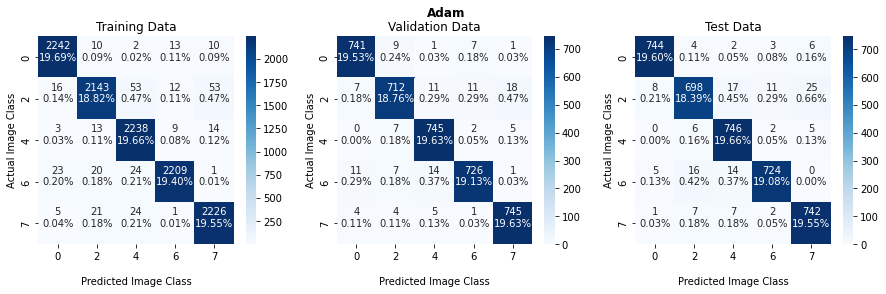

	Training Data				Validation Data				Test Data
Accuracy: 0.9713				0.9668					0.9628
Precision:0.9714				0.9668					0.963
Recall:   0.9713				0.9668					0.9628
F1-Score: 0.9712				0.9667					0.9627


In [ ]:
#FCNN using Adam optimizer for classification.
node1 = 30
node2 = 20
node3 = 10
C = 5
error_th = 1e-4
p = 1

optimizer  ='Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_3_layer(x_train_compress,y_train,x_val_compress,y_val,x_test_compress,y_test,
            node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

##**`Denoising AutoEncoder with 1 Hidden Layers`**

In [ ]:
class noiseLayer(tf.keras.layers.Layer):
  def __init__(self,noise_pct,mean,std):
    super(noiseLayer, self).__init__()
    self.noise_pct = noise_pct
    self.mean = mean
    self.std  = std

  def call(self, input):
    mean = self.mean
    std  = self.std
    noise = np.random.normal(size = [784],loc = mean,scale = std)
    #if np.random.rand()*100>noise_pct:
    #  noise *= 0
    index = list(range(len(noise)))
    np.random.shuffle(index)
    noise[index[int(self.noise_pct/100*len(noise)):]] = 0
    noise = tf.convert_to_tensor(noise,dtype=np.float32)
    return input + noise

# Denoising Auto Encoder
def denoising_autoencoder_1_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,optimizer,batch_size,error_th,noise_pct,epochs=1e3):
  model = Sequential()
  model.add(noiseLayer(noise_pct,mean=0,std=1/np.sqrt(784)))
  model.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid'))
  model.add(Dense(x_train.shape[1], activation='linear'))
  
  es = EarlyStopping(monitor='loss',mode='min',min_delta = error_th,verbose=1,patience=1)

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
  history = model.fit(x_train, x_train,validation_data = (x_val,x_val) ,epochs=int(epochs), 
                      batch_size=batch_size,callbacks=[es])
  
  print("No of Epochs =",len(history.history["loss"]))
  plt.figure(figsize=(12.5,8))
  plt.suptitle("1 Hidden Layer",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.plot(history.history['loss'],marker='.')
  plt.plot(history.history['val_loss'],marker='.')
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid()
  plt.tight_layout();plt.show()

  print("Training Loss\t=",history.history['loss'][-1])
  print("Validation Loss\t=",history.history['val_loss'][-1])
  
  x_train_pred = model.predict(x_train)
  x_val_pred   = model.predict(x_val)
  x_test_pred  = model.predict(x_test)
  test_loss = ((x_test-x_test_pred)**2).mean()
  print("Test Loss\t=",test_loss)
  
  plt.figure(figsize=(12.5,4))
  plt.suptitle("Average Reconstruction Error vs Data",fontweight="bold",y=1+1e-2)
  plt.subplot(1,1,1)
  plt.bar(height = [history.history['loss'][-1],history.history['val_loss'][-1],test_loss],x = ['Training Data','Validation Data','Test Data'])
  plt.ylabel('Average Reconstruction Error') 
  plt.xlabel('Data') 
  plt.grid()
  plt.tight_layout();plt.show()


  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  C = set(y_train)
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Training Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_train_pred[y_train==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nOriginal Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:  
    plt.subplot(1,5,index)
    plt.imshow(x_val[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(12.5,4))
  plt.suptitle("Validation Set\nReconstructed Image",fontweight="bold",y=1+1e-2)  
  index = 1
  for i in C:
    plt.subplot(1,5,index)
    plt.imshow(x_val_pred[y_val==i][0].reshape(28,28),cmap='gray')
    plt.title("Class "+str(int(i)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Weight Visualization
  plt.figure(figsize=(12.5,node1))
  plt.suptitle("Weight Vizualization",fontweight="bold",y=1+1e-2)  
  weights = model.layers[1].get_weights()
  
  index = 1
  for i in range(8):#node1):
    plt.subplot(node1//4,4,index)
    img = weights[0].T[i]
    img /= np.sqrt(sum(img**2))
    plt.imshow(img.reshape(28,28),cmap='gray')
    plt.title("Hidden Node "+str(int(i+1)))
    plt.xticks([]);plt.yticks([])
    index+=1
  plt.tight_layout()
  plt.show()

  #Encoder
  model2 = Sequential()
  model.add(noiseLayer(noise_pct,mean=0,std=1/np.sqrt(784)))
  model2.add(Dense(node1, input_dim=x_train.shape[1], activation='sigmoid', weights=model.layers[1].get_weights()))

  x_train_compress = model2.predict(x_train)
  x_val_compress = model2.predict(x_val)
  x_test_compress = model2.predict(x_test)
  return x_train_compress,x_val_compress,x_test_compress

Epoch 1/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 2/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 3/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 4/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 6/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoc

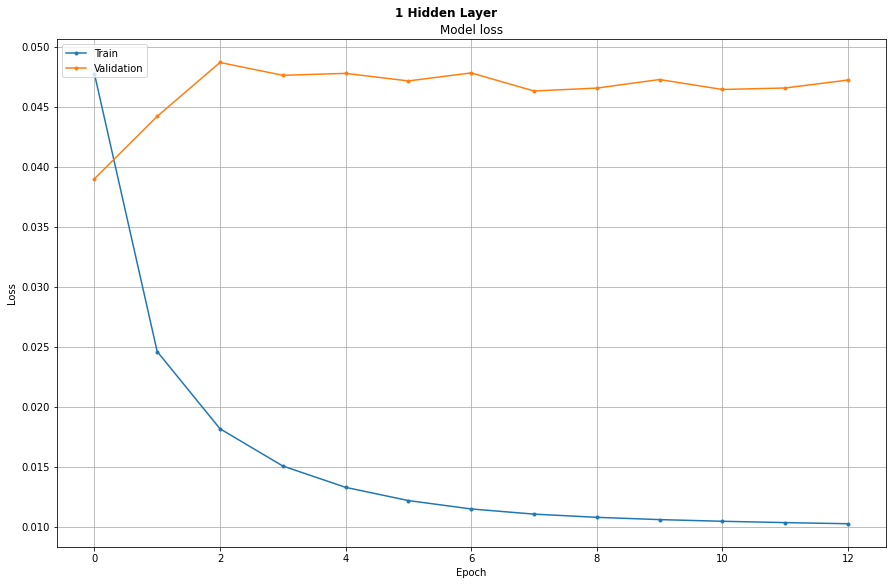

Training Loss	= 0.010278318077325821
Validation Loss	= 0.04722589626908302
Test Loss	= 0.04227906407872852


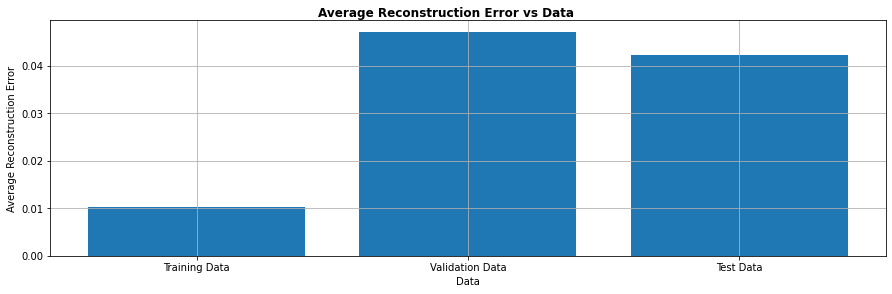

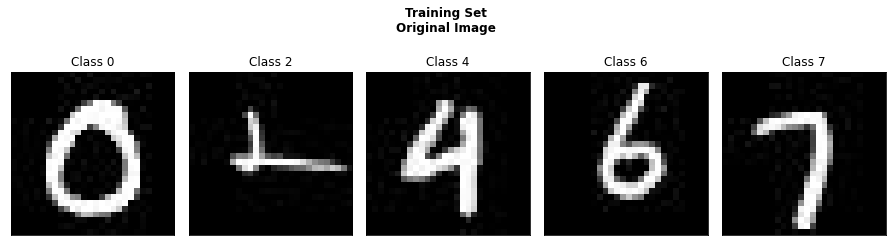

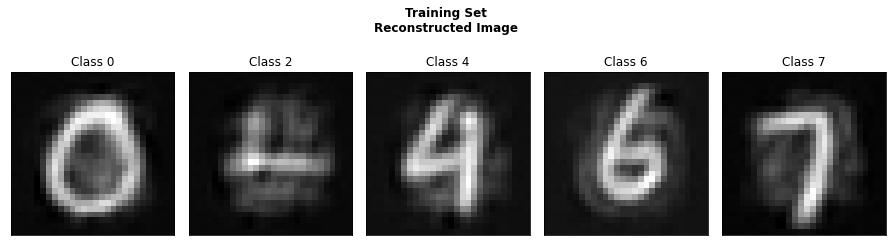

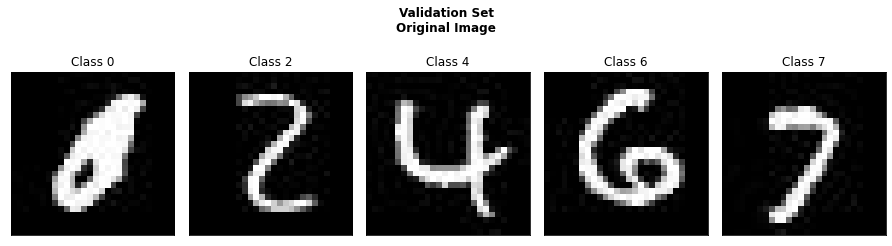

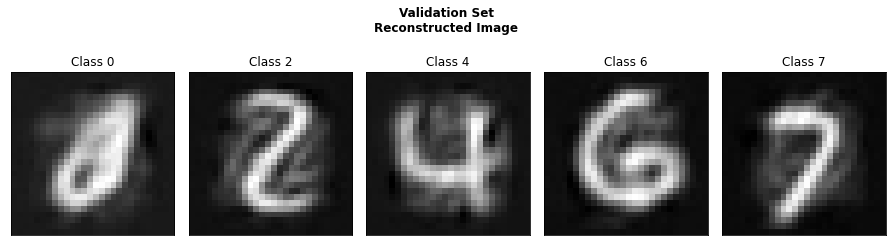

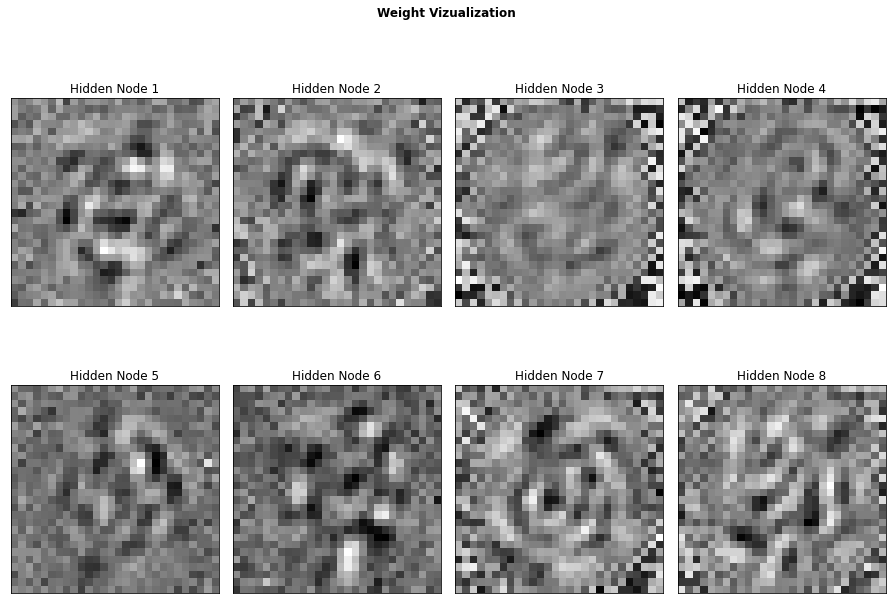

In [ ]:
node1 = 64
epochs = 1e5
error_th = 1e-4
optimizer = 'Adam'
batch_size = 32
noise_pct = 100
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
x_train_compress,x_val_compress,x_test_compress = denoising_autoencoder_1_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,optimizer,batch_size,error_th,noise_pct,epochs)

Epoch 1/100000
356/356 [==============================] - 2s 3ms/step - loss: 1.6121 - accuracy: 0.2797 - val_loss: 1.5660 - val_accuracy: 0.4303
Epoch 2/100000
356/356 [==============================] - 1s 2ms/step - loss: 1.3841 - accuracy: 0.6256 - val_loss: 1.1227 - val_accuracy: 0.7080
Epoch 3/100000
356/356 [==============================] - 1s 2ms/step - loss: 0.9557 - accuracy: 0.7405 - val_loss: 0.8212 - val_accuracy: 0.8032
Epoch 4/100000
356/356 [==============================] - 1s 2ms/step - loss: 0.7224 - accuracy: 0.8328 - val_loss: 0.6283 - val_accuracy: 0.8553
Epoch 5/100000
356/356 [==============================] - 1s 2ms/step - loss: 0.5297 - accuracy: 0.8885 - val_loss: 0.4488 - val_accuracy: 0.9051
Epoch 6/100000
356/356 [==============================] - 1s 2ms/step - loss: 0.3789 - accuracy: 0.9190 - val_loss: 0.3301 - val_accuracy: 0.9207
Epoch 7/100000
356/356 [==============================] - 1s 2ms/step - loss: 0.2908 - accuracy: 0.9312 - val_loss: 0.2583 -

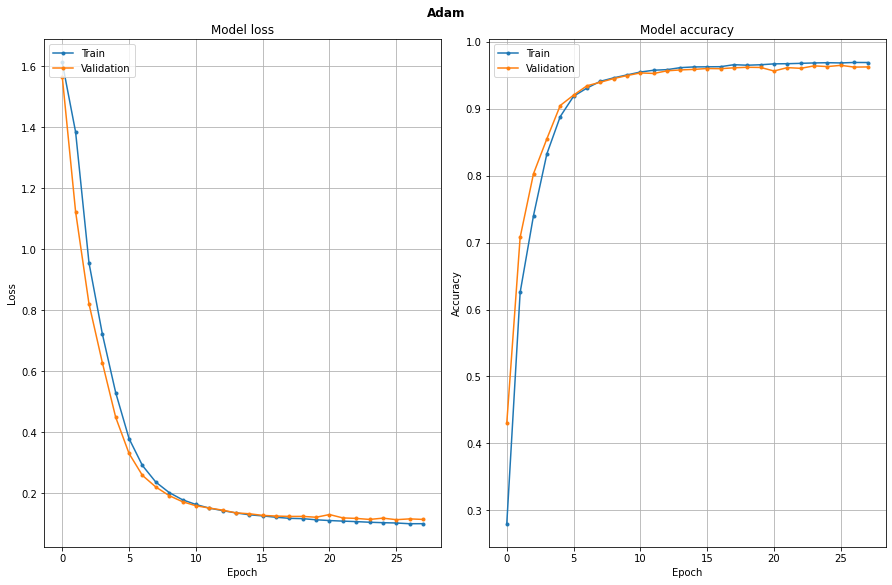

Training Accuracy =	 0.9694334864616394
Validation Accuracy =	 0.9628458619117737


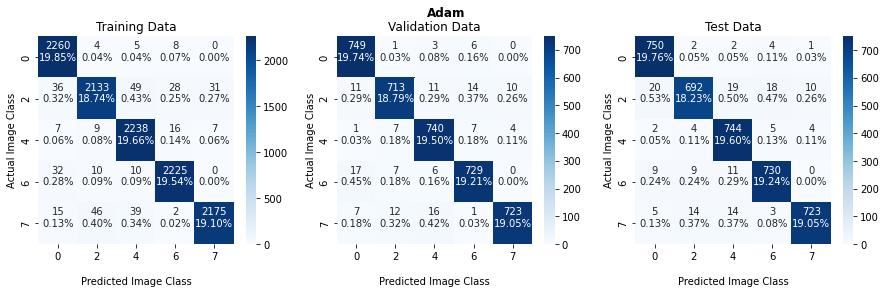

	Training Data				Validation Data				Test Data
Accuracy: 0.9689				0.9628					0.9589
Precision:0.9691				0.9631					0.9592
Recall:   0.9689				0.9628					0.9589
F1-Score: 0.9688				0.9628					0.9587


In [ ]:
#FCNN using Adam optimizer for classification.
node1 = 30
node2 = 20
node3 = 10
C = 5
error_th = 1e-4
p = 1

optimizer  ='Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_3_layer(x_train_compress,y_train,x_val_compress,y_val,x_test_compress,y_test,
            node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)

Epoch 1/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 2/100000
356/356 [==============================] - 2s 4ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 3/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 4/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 6/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoc

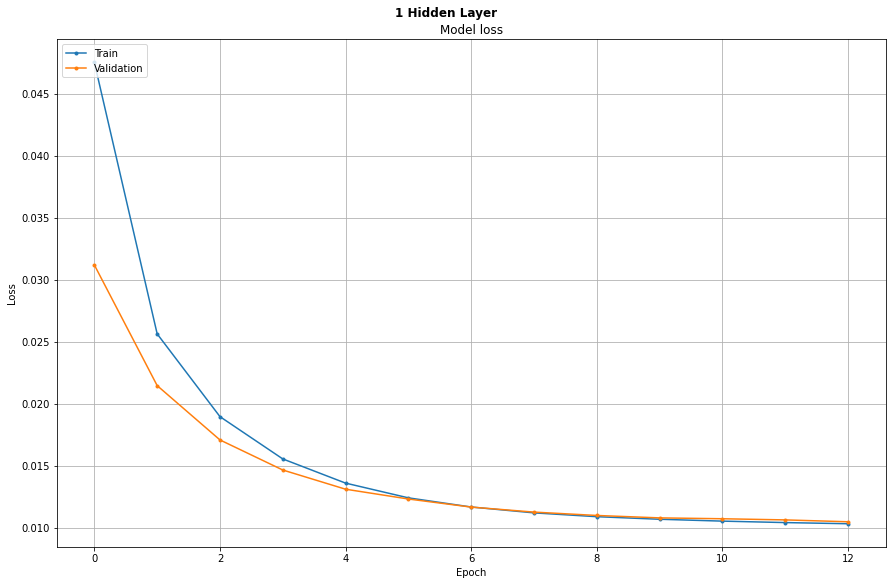

Training Loss	= 0.010320435278117657
Validation Loss	= 0.010479887016117573
Test Loss	= 0.01046114292332836


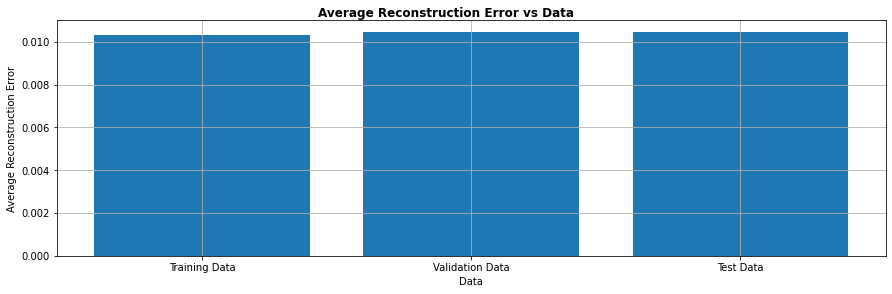

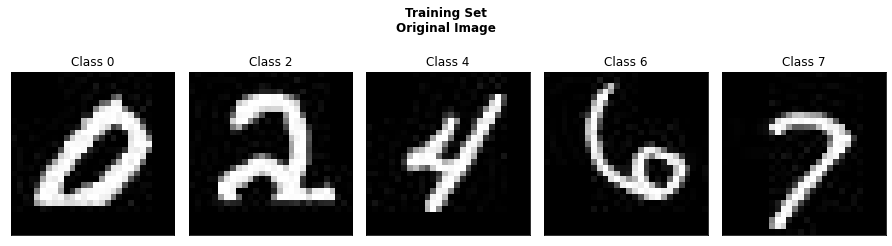

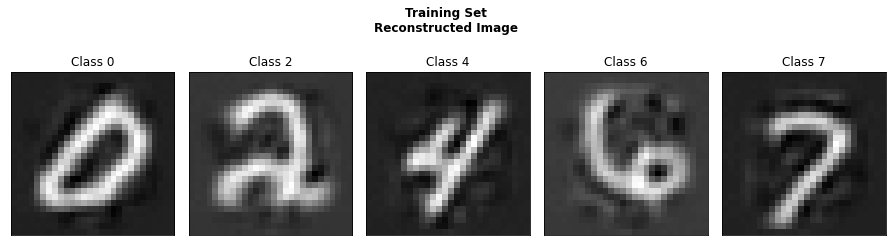

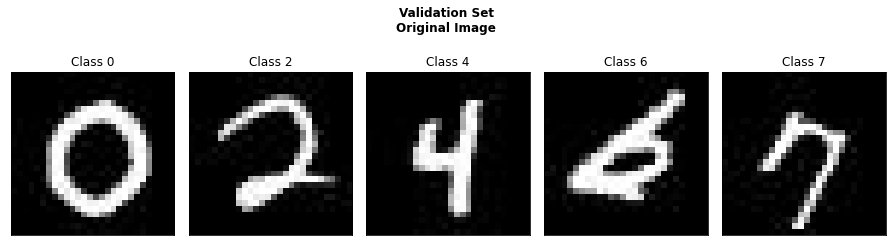

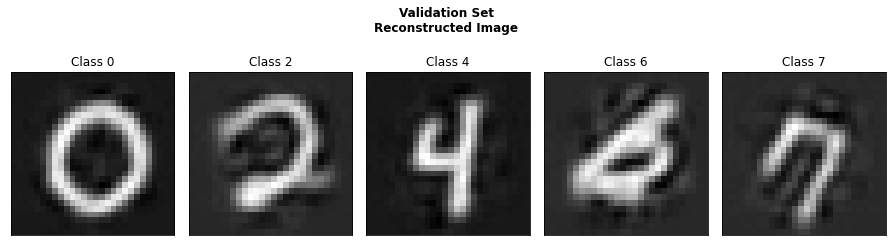

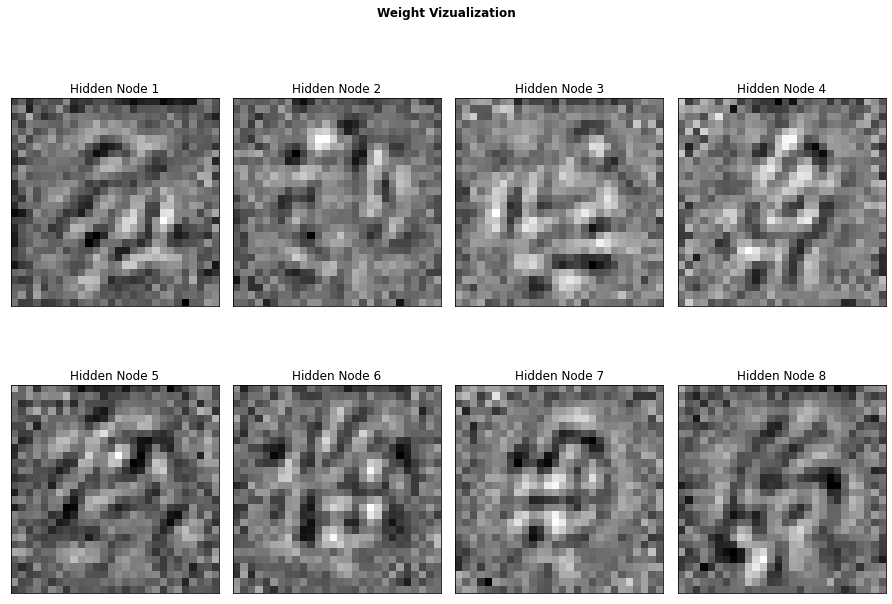

In [ ]:
node1 = 64
epochs = 1e5
error_th = 1e-4
optimizer = 'Adam'
batch_size = 32
noise_pct = 40
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
x_train_compress,x_val_compress,x_test_compress = denoising_autoencoder_1_layer(x_train,x_val,x_test,y_train,y_val,y_test,node1,optimizer,batch_size,error_th,noise_pct,epochs)

Epoch 1/100000
356/356 [==============================] - 2s 4ms/step - loss: 1.5843 - accuracy: 0.3412 - val_loss: 1.5032 - val_accuracy: 0.6300
Epoch 2/100000
356/356 [==============================] - 1s 3ms/step - loss: 1.2109 - accuracy: 0.7398 - val_loss: 0.9058 - val_accuracy: 0.8551
Epoch 3/100000
356/356 [==============================] - 1s 4ms/step - loss: 0.6950 - accuracy: 0.8776 - val_loss: 0.5245 - val_accuracy: 0.9167
Epoch 4/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.9306 - val_loss: 0.3285 - val_accuracy: 0.9420
Epoch 5/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.2802 - accuracy: 0.9461 - val_loss: 0.2415 - val_accuracy: 0.9476
Epoch 6/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.2187 - accuracy: 0.9505 - val_loss: 0.2009 - val_accuracy: 0.9513
Epoch 7/100000
356/356 [==============================] - 1s 3ms/step - loss: 0.1876 - accuracy: 0.9537 - val_loss: 0.1904 -

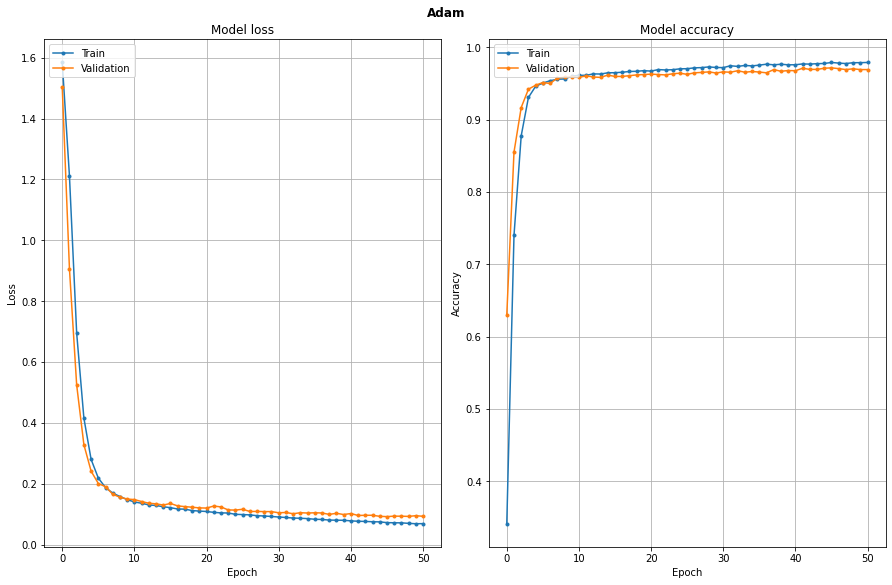

Training Accuracy =	 0.9790074825286865
Validation Accuracy =	 0.9691699743270874


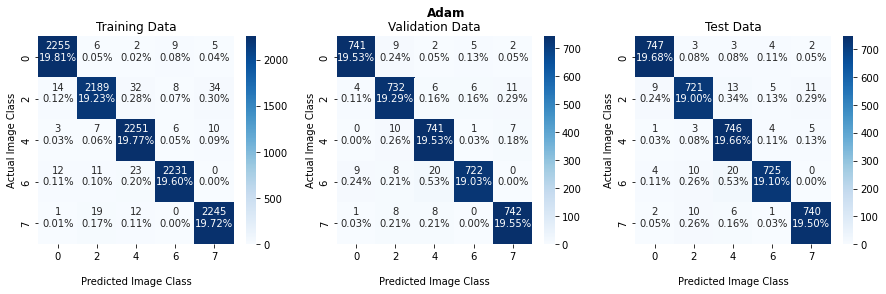

	Training Data				Validation Data				Test Data
Accuracy: 0.9812				0.9692					0.9694
Precision:0.9813				0.9694					0.9696
Recall:   0.9812				0.9692					0.9694
F1-Score: 0.9812				0.9692					0.9694


In [ ]:
#FCNN using Adam optimizer for classification.
node1 = 30
node2 = 20
node3 = 10
C = 5
error_th = 1e-4
p = 1

optimizer  ='Adam'
batch_size = 32
tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
clf_3_layer(x_train_compress,y_train,x_val_compress,y_val,x_test_compress,y_test,
            node1,node2,node3,C,optimizer,batch_size,error_th,p,epochs=1e5)